In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Loading the natural gas data
df = pd.read_csv("Nat_Gas.csv")

df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [32]:
# Normalization
df.columns = df.columns.str.strip().str.lower()
df.columns

Index(['dates', 'prices'], dtype='str')

In [35]:
# Covert the date column to datetime and sort by date
df['dates'] = pd.to_datetime(df['dates'])
df = df.sort_values('dates').reset_index(drop=True)
df.info(), df.head()

<class 'pandas.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dates   48 non-null     datetime64[us]
 1   prices  48 non-null     float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 900.0 bytes


(None,
        dates  prices
 0 2020-10-31    10.1
 1 2020-11-30    10.3
 2 2020-12-31    11.0
 3 2021-01-31    10.9
 4 2021-02-28    10.9)

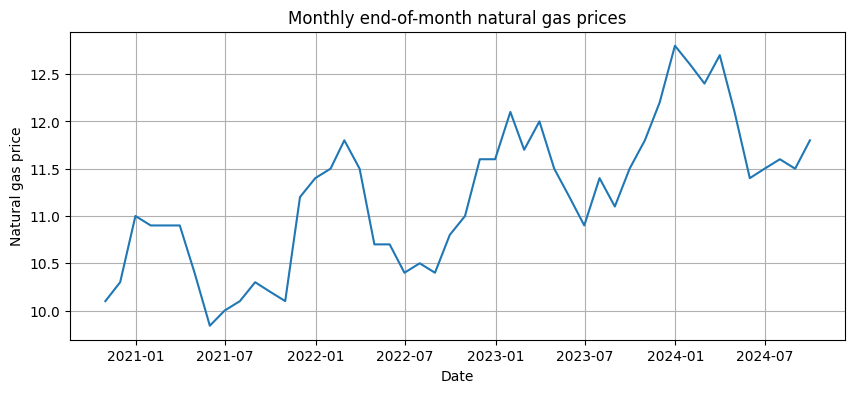

In [37]:
# Plot the monthly series
plt.figure(figsize=(10,4))
plt.plot(df['dates'], df['prices'])
plt.xlabel("Date")
plt.ylabel("Natural gas price")
plt.title("Monthly end-of-month natural gas prices")
plt.grid(True)
plt.show()

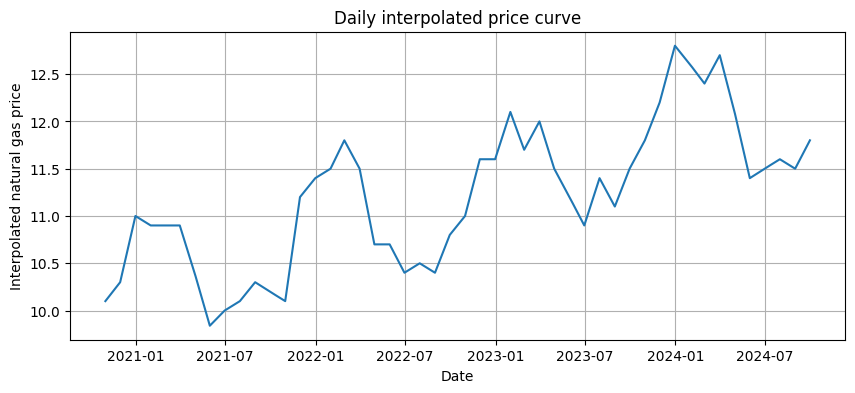

In [39]:
# 1. Define first and last known 
start_date = df['dates'].min()  # earliest date in file
end_date   = df['dates'].max()  # latest date in file

# 2. Create a daily date index start -> end
daily_index = pd.date_range(start=start_date, end=end_date, freq='D')

# 3. Reindex the dataframe to the daily index
daily = df.set_index('dates').reindex(daily_index)
daily.index.name = 'dates'

# 4. Interpolate missing prices (time-based interpolation)
daily['prices'] = daily['prices'].interpolate(method='time')
daily.head(), daily.tail()

# Plot Check
plt.figure(figsize=(10,4))
plt.plot(daily.index, daily['prices'])
plt.xlabel("Date")
plt.ylabel("Interpolated natural gas price")
plt.title("Daily interpolated price curve")
plt.grid(True)
plt.show()

In [41]:
# Computing average price by calendar month
df['month'] = df['dates'].dt.month                  # Add a month column
month_avg = df.groupby('month')['prices'].mean()    # Average price per month

month_avg

month
1     11.775
2     11.700
3     11.775
4     11.175
5     10.785
6     10.700
7     10.900
8     10.825
9     11.075
10    10.750
11    11.325
12    11.700
Name: prices, dtype: float64

In [ ]:
# Defining the end of the future horizon (1 year after last date)
future_end = end_date + pd.DateOffset(years=1)

# Future monthly prices based on seasonal monthly averages
future_index = pd.date_range( start=end_date + pd.Timedelta(days=1), end=future_end, freq='D')
future = pd.DataFrame(index=future_index)
future.index.name = 'dates'
future['month'] = future.index.month
future['prices'] = future['month'].map(month_avg)

future.head(), future.tail()

(            month  prices
 dates                    
 2024-10-01     10   10.75
 2024-10-02     10   10.75
 2024-10-03     10   10.75
 2024-10-04     10   10.75
 2024-10-05     10   10.75,
             month  prices
 dates                    
 2025-09-26      9  11.075
 2025-09-27      9  11.075
 2025-09-28      9  11.075
 2025-09-29      9  11.075
 2025-09-30      9  11.075)

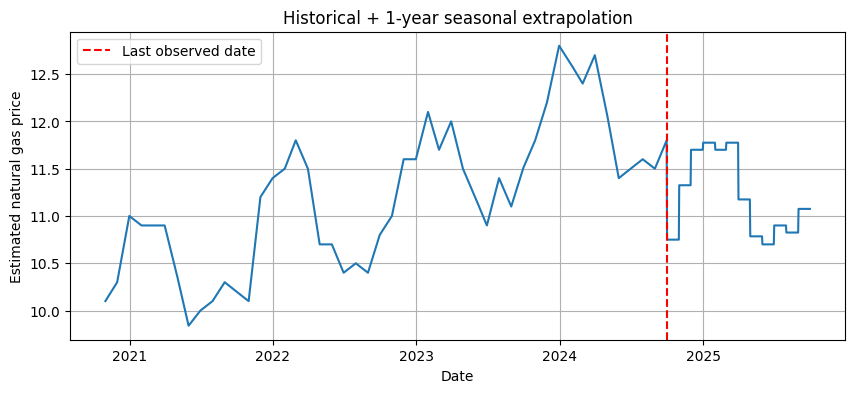

In [50]:
# Combining historical daily and future daily into one full series
full = pd.concat([daily[['prices']], future[['prices']]]).sort_index()

plt.figure(figsize=(10,4))
plt.plot(full.index, full['prices'])
plt.axvline(end_date, color='red', linestyle='--', label="Last observed date")
plt.xlabel("Date")
plt.ylabel("Estimated natural gas price")
plt.title("Historical + 1-year seasonal extrapolation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to estimate price for any date
def estimate_nat_gas_price(date_str):
    """
    Estimate natural gas price from a given date string "YYYY-MM-DD
    
    Uses:
    - interpolated historical data
    - seasonal monthly average extrapolation for up to 1 year after last date
    """
    
    # Convert string to timestamp
    date = pd.to_datetime(date_str)
    
    # Check bounds: start of history to one year after end_date
    if date < full.index.min() or date > full.index.max():
        raise ValueError(f"(Date out of supported range {full.index.min().date()} to {full.index.max().date()})")
    if date in full.index:
        return float(full.loc[date, 'prices'])
    
    # Otherwise interpolate within full daily range
    full_sorted = full.sort_index()
    daily_full = full_sorted['prices'].reindex(pd.date_range(full_sorted.index.min(), full_sorted.index.max(), freq='D')).interpolate('time')
    
    return float(daily_full.loc[date])
print("Price on 2022-03-15:", estimate_nat_gas_price("2022-03-15"))
print("Price on 2025-02-01:", estimate_nat_gas_price("2025-02-01"))


Price on 2022-03-15: 11.654838709677419
Price on 2025-02-01: 11.7
